#Introduction

.....


Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

Der Befehl "which" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


# Install dependencies:

In [2]:
install_packages = False
if install_packages:
    !conda install tensorflow=2 -y
    !conda install -c anaconda pandas -y
    !conda install -c conda-forge tensorflow-hub -y
    !conda install -c akode html2text -y
    !conda install -c conda-forge tqdm -y
    !conda install -c anaconda scikit-learn -y
    !conda install -c conda-forge matplotlib -y
    !conda install -c anaconda seaborn -y

# Imports

In [3]:
#imports
import pandas as pd
import numpy as np
import os
import time
import tensorflow as tf
import tensorflow_hub as hub
import zipfile
from html2text import HTML2Text
from tqdm import tqdm
import re
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas print options
This will improve readability of printed pandas dataframe.


In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

data_path: In this path put the data you have downloaded with YouTube Data Tools. 
output_path: Tghe files generated in this notebook will be saved here.

url_dict: URLs to models on Tensorflow hub are saved here. Other models are available there.
model_type: Define which model you would like to use. Choose one from url_dict

new_embeddings: If this is true, new embeddings will be generated and saved at output_path. Otherwise, embeddings are loaded from Disc.




In [5]:
data_path = './data/videoinfo_k1oPVp63eNk_2020_12_01-08_43_03_comments.tab'
output_path = "./output/"

new_embeddings = True

url_dict = {
            'Transformer' : "https://tfhub.dev/google/universal-sentence-encoder-large/5",
            'DAN' : "https://tfhub.dev/google/universal-sentence-encoder/4",
            'Transformer_Multilingual': "https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3"
}

model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

## Create output directory
Try to create the directory defined by output_path

In [6]:
try:
    os.mkdir(output_path)
except OSError:
    print ("Creation of the directory %s failed" % output_path)
else:
    print ("Successfully created the directory %s " % output_path)


Creation of the directory ./output/ failed


# Load Data
Load you data as a pandas dataframe

In [7]:
if new_embeddings:
    data = pd.read_csv(data_path,sep='\t',header=(0))
    data.head()

# Preprocessing
Preprocess your data:
- Drop empty rows
- Drop unused columns

In [8]:
if new_embeddings:
    data = data.dropna(subset=['text', 'authorName']) # drop rows with no content
    data=data.drop(['id', 'replyCount','likeCount','authorChannelUrl','authorChannelId','isReplyTo','isReplyToName'],axis=1) # drop unused columns
    data.head()

- remove HTML-tags, links and usernames

In [9]:
if new_embeddings:
    # Remove HTML tags
    tqdm.pandas()
    h = HTML2Text()
    h.ignore_links = True
    data['cleaned'] = data['text'].progress_apply(lambda x: h.handle(x))
    print( "Removed HTML Tags.")

    # Remove links
    http_link_pattern = r'http\S+'
    bitly_link_pattern = r'bit.ly/\S+'
    data['cleaned'] = data['cleaned'].str.replace(http_link_pattern, '')
    data['cleaned'] = data['cleaned'].str.replace(bitly_link_pattern, '')
    print( "Removed Links.")

    # Remove user names
    keep_names = ["earth", "Tide", "Geologist", "A Person", "Titanic", "adventure", "Sun", "The United States Of America"] # user names we want to keep
    user_names = [name for name in data['authorName'].unique() if (len(name)> 3 and name not in keep_names)]
    data['cleaned'] = data['cleaned'].str.replace('|'.join(map(re.escape, user_names)), '')
    print( "Removed user names.")

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|████████████████████████████████████████████████████████████████████████████| 1069/1069 [00:00<00:00, 7548.27it/s]


Removed HTML Tags.
Removed Links.
Removed user names.


# Save or Load preprocessed data

Save your data afte preprocessing, or load preprocessed data from disc.

In [10]:
if new_embeddings:
    data.to_pickle(output_path+'data_preprocessed'+'.pkl')
else:
    data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
data.head()

,publishedAt,authorName,text,isReply,cleaned
0,2020-11-30 12:20:35,Tree to One 회기나무,"Wrong Geography, TED...",0,"Wrong Geography, TED...\n\n"
1,2020-11-30 05:47:25,TransHuman,"The rich will kill all of us before they will do anything that cuts into there profits so at some point we are going to have to force our governments to stop supporting oligarchies, monopoly&#39;s and predatory capitalism before we can get them to stop diving us toward mass extinction.",0,"The rich will kill all of us before they will do anything that cuts into there\nprofits so at some point we are going to have to force our governments to stop\nsupporting oligarchies, monopoly's and predatory capitalism before we can get\nthem to stop diving us toward mass extinction.\n\n"
2,2020-11-29 23:01:55,Aku Tenshi,Someone missed their geography class....,0,Someone missed their geography class....\n\n
3,2020-11-29 03:03:19,CHUNKYNUGGET666,Bullshit 2 days from summer and it’s still winter here in Australia..,0,Bullshit 2 days from summer and it’s still winter here in Australia..\n\n
4,2020-11-28 13:42:33,rajveer munde,where did kashmir go from india?,0,where did kashmir go from india?\n\n


# Produce Text Embeddings with Universal Sentence Encoder

## Load Model
Load the model from TF-hub

In [11]:
hub_url = url_dict[model_type]
if new_embeddings:
    print("Loading model. This will take some time...")
    embed = hub.load(hub_url)

Loading model. This will take some time...


## Embed Documents
Produce embeddings of your documents.

In [12]:
if new_embeddings:
    for k,g in data.groupby(np.arange(len(data))//200):
        if k == 0:
            embeddings = embed(g['cleaned'])
        else:
            embeddings_new = embed(g['cleaned'])
            embeddings = tf.concat(values=[embeddings,embeddings_new],axis = 0)
            print(k , end =" ")
    print("The embeddings vector is of fixed length {}".format(embeddings.shape[1]))

    np.save(output_path+'/embeddings'+model_type+'.npy', embeddings, allow_pickle=True, fix_imports=True)
else:
    embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

embeddings.shape

1 2 3 4 5 The embeddings vector is of fixed length 512


TensorShape([1069, 512])

## Calculate Similarity Matrix with angular distance

'Following Cer et al. (2018), we first compute
the sentence embeddings u, v for an STS sentence
pair, and then score the sentence pair similarity
based on the angular distance between the two
embedding vectors  d = − arccos (uv/||u|| ||v||).'

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(input_vectors):
    similarity = cosine_similarity(input_vectors)
    return similarity
cosine_similarity_matrix = cos_sim(np.array(embeddings))
print(cosine_similarity_matrix)

[[ 1.0000001  -0.06471513  0.70177853 ...  0.1008552   0.04293023
   0.19664134]
 [-0.06471513  1.         -0.03971552 ...  0.06374824  0.01989877
   0.09678731]
 [ 0.70177853 -0.03971552  1.0000002  ...  0.01410054  0.15953971
   0.18985346]
 ...
 [ 0.1008552   0.06374824  0.01410054 ...  1.         -0.00853094
   0.02845212]
 [ 0.04293023  0.01989877  0.15953971 ... -0.00853094  1.
   0.00493802]
 [ 0.19664134  0.09678731  0.18985346 ...  0.02845212  0.00493802
   1.        ]]


# Plots Similarity 
Plot and print a heat map showing the semantic contextual similarity between comments.

1069


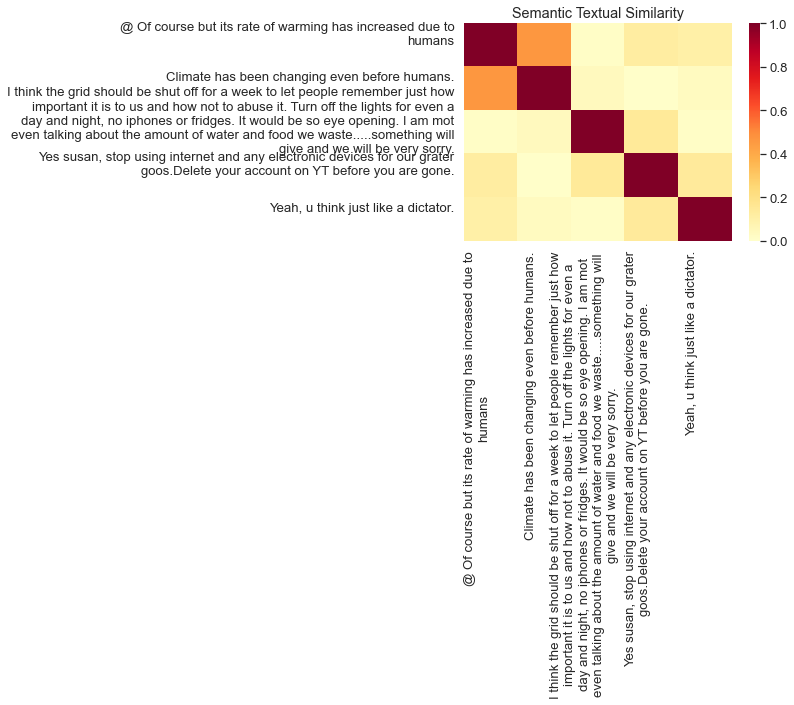

In [22]:
import seaborn as sns
def plot_similarity(labels, features, rotation):
    #print('label: ',labels)
    #print('feature: ',features)
    #print('rotation: ',rotatation)
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
    corr,
    xticklabels=labels,
    yticklabels=labels,
    vmin=0,
    vmax=1,
    cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")

num_samples = 5
off_set = 1000

print(len(data['cleaned']))

plot_similarity(data.iloc[off_set:off_set+num_samples]['cleaned'], embeddings[off_set:off_set+num_samples], 90)

# Show neighbours of a comment 
Define which comment to analyze

In [18]:
comment_index = 324
comment = data["cleaned"][comment_index]
comment_list = data["cleaned"].tolist()
print(comment)

​@ I think Tom just said climate change didn't have solutions nor will be
solved. He does not deny climate change.




Print similar comments.

In [24]:
def get_top_similar(sentence, sentence_list, similarity_matrix, topN):
    # find the index of sentence in list
    index = sentence_list.index(sentence)
    # get the corresponding row in similarity matrix
    similarity_row = np.array(similarity_matrix[index, :])
    # get the indices of top similar
    indices = similarity_row.argsort()[-topN:][::-1]
    return [sentence_list[i] for i in indices]


for i, value in enumerate(get_top_similar(comment, comment_list, cosine_similarity_matrix, 1000)):
    print("Top similar comment {}: {}".format(i+1, value))

Top similar comment 1: ​@ I think Tom just said climate change didn't have solutions nor will be
solved. He does not deny climate change.


Top similar comment 2: @Tom Wickford "Climate change" is natural, man-made catastrophic global
warming/climate change is a scam.


Top similar comment 3: @Tom Wickford we've known for decades that greenhouse gases attack the ozone
layer. We've known for decades that if the ozone layer gets smaller,
temperature rises. Now that we burned greenhouse gases for 200 years all over
the world, those didn't do anything mate, obviously. You can literally see the
exact same graph for co² levels in the atmosphere and temperature change.
There are solutions obviously, but no one cares because there is no lobby
bribing our politicians. Literally half of all coal plants are losing money
for example, but if you just bribe enough it's fine. And no i don't believe we
*will* stop climate change because we humans are too dumb. We have barely 10
years left before it's 